# Tracking loss in optimizations

Qiskit provides a collections of classical optimizers in ``qiskit.algorithms.optimizers``. These are entirely classical algorithms and work on any blackbox function. Here we can for example use

In [1]:
import numpy as np

def f(x):
    return -np.exp(np.sin(5 - 0.5 * x[0]) * np.cos(2 + x[1]))

In [2]:
x = np.linspace(-np.pi, np.pi, num=50)
X, Y = np.meshgrid(x, x)
Z = [[f([x_i, x_j]) for x_i in x] for x_j in x]

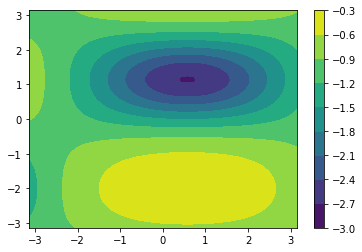

In [3]:
import matplotlib.pyplot as plt

plt.contourf(X, Y, Z)
plt.colorbar()

To track information about the optimization process we can use so-called "callbacks". These are nothing but functions that are called in each step of the minimization. Depending on the optimizer the callbacks can get different input arguments, which we will explore in the following.

### SciPy-based minimizers

Many optimizers in ``qiskit.algorithms.optimizers`` wrap optimizers from SciPy. Most of those -- but not all! -- support a callback. Check the [SciPy docs](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.optimize.minimize.html) for more detailed information.

If the optimizer (as for example the `L_BFGS_B` optimizer) supports a callback, the callback is usually passed the current parameter values. Based on these, we can compute the loss. We could also use this callback to store the parameter values and plot the path in the loss landscape.

In [4]:
from qiskit.algorithms.optimizers import L_BFGS_B

Now we can define a callback as a function that takes the current parameter value as input and has no return value. Here we are storing the parameter values and the associated loss in two separate lists.

In [5]:
parameters = []
loss = []
def store_history(x):
    parameters.append(x)
    loss.append(f(x))
    
x0 = [-1, 0]
optimizer = L_BFGS_B(callback=store_history)

result = optimizer.minimize(f, x0)

With this information we can plot the loss per iteration...

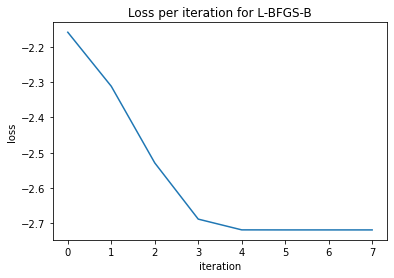

In [6]:
plt.title("Loss per iteration for L-BFGS-B")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(loss)

... or the path in the loss landscape!

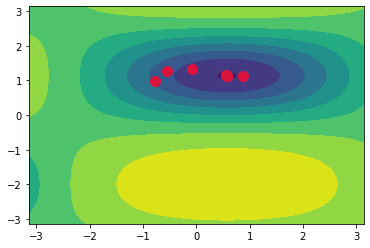

In [7]:
plt.contourf(X, Y, Z)
plt.scatter([x[0] for x in parameters], [x[1] for x in parameters], color="crimson", s=100)

If an optimizer does not support a callback, you'll see the following warning:

In [8]:
from qiskit.algorithms.optimizers import COBYLA

In [9]:
parameters = []
loss = []
def store_history(x):
    parameters.append(x)
    loss.append(f(x))
    
x0 = [-1, 0]
optimizer = COBYLA(callback=store_history)

result = optimizer.minimize(f, x0)

/Users/jul/opt/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/optimize/_minimize.py:545: RuntimeWarning: Method cobyla does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


### Qiskit's optimizers

Other optimizers, such as SPSA or gradient descent, are directly implemented in Qiskit (that's because SciPy does not offer them). For these, the callback is given more information than just the parameters, namely: the current number of function evaluations, the current parameters and the current loss. Note that individual optimizers may have more additional information.

In [10]:
from qiskit.algorithms.optimizers import SPSA

In [11]:
parameters = []
loss = []
def store_history(nit, x, fx, *args):
    parameters.append(x)
    loss.append(fx)
    
x0 = [-1, 0]
optimizer = SPSA(callback=store_history)

result = optimizer.minimize(f, x0)

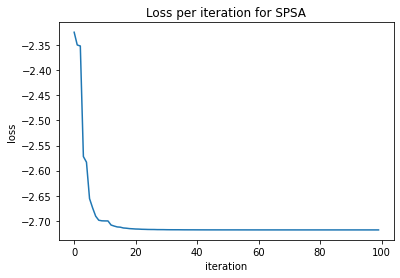

In [12]:
plt.title("Loss per iteration for SPSA")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(loss)

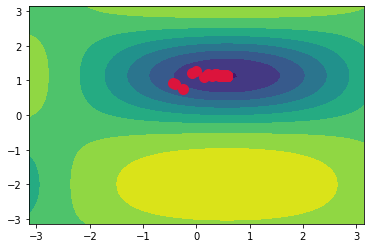

In [13]:
plt.contourf(X, Y, Z)
plt.scatter([x[0] for x in parameters], [x[1] for x in parameters], color="crimson", s=100)

## Variational quantum algorithms

With out current near-term quantum computers we often use optimizers in the context of variational algorithms, such as the VQE. We can apply what we've learned above to track the energy of the VQE!

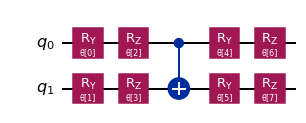

In [19]:
from qiskit import BasicAer
from qiskit.algorithms import VQE
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import X, Y, Z

observable = (X ^ 2) + (Y ^ 2) - (Z ^ 2)
ansatz = EfficientSU2(2, reps=1)
backend = BasicAer.get_backend("statevector_simulator")

ansatz.decompose().draw("mpl", style="iqx")

In [20]:
parameters = []
loss = []
def store_history(nit, x, fx, *args):
    parameters.append(x)
    loss.append(fx)
    
optimizer = SPSA(callback=store_history)

In [21]:
vqe = VQE(ansatz, optimizer, quantum_instance=backend)
vqe_result = vqe.compute_minimum_eigenvalue(observable)

Let's get a reference solution to check whether the VQE has reached the correct minimum.

In [25]:
from qiskit.algorithms import NumPyMinimumEigensolver

exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(observable)

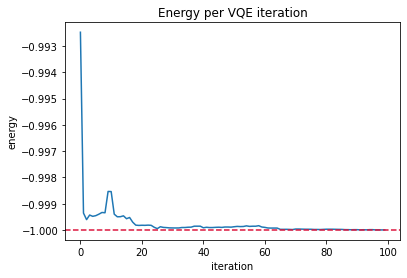

In [27]:
plt.xlabel("iteration")
plt.ylabel("energy")
plt.title("Energy per VQE iteration")
plt.plot(loss)
plt.axhline(exact_result.eigenvalue.real, color="crimson", ls="--")

You could also use the ``callback`` argument of the ``VQE`` class itself, but note that this gives information _on each function call_! Depending on the optimizer, the function might be called several times in each step.

The callback in the optimizers on the other hand is only called _in each iteration_.

In a concrete example: SPSA uses two function evaluations per iteration (since it approximates the gradient with two evaluations). Additionally it will calibrate the learning rate with 50 initial function evaluations.
The callback in the VQE will return information on each of these evaluations, not the current point in the optimization.

In [34]:
parameters = []
loss = []
def store_history(nfev, x, mean, std):
    # VQE returns the total number of function evaluations (nfev), the parameters (x),
    # the mean of the observable/the energy (mean) and the standard deviation (std)
    parameters.append(x)
    loss.append(mean)

In [35]:
vqe = VQE(ansatz, optimizer=SPSA(maxiter=100), callback=store_history, quantum_instance=backend)
vqe_result = vqe.compute_minimum_eigenvalue(observable)

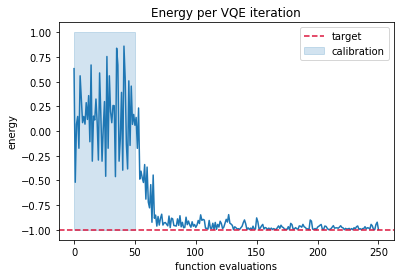

In [47]:
plt.xlabel("function evaluations")
plt.ylabel("energy")
plt.title("Energy per VQE iteration")
plt.plot(loss)
plt.axhline(exact_result.eigenvalue.real, color="crimson", ls="--", label="target")
plt.fill_betweenx(y=[-1,1], x1=0, x2=50, color="tab:blue", alpha=0.2, label="calibration")
plt.legend(loc="best")